# Zero-shot MLM approach with bert-base
The key idea is to inject [MASK] token into sentence and look at model's output for [MASK] token comparing logits corresponding to ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'] words. Which one is max that's class text considers to be.


In [1]:
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt



In [2]:

# Load the dataset
dataset = load_dataset('dair-ai/emotion')

# Convert to pandas dataframe
train_data = pd.DataFrame(dataset['train'])
val_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

print(train_data.head())
print(test_data.head())

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0


In [3]:
train_data['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [4]:
train_data = train_data.drop_duplicates(subset='text')
train_data = train_data.reset_index(drop=True)

In [5]:
train_data.isna().values.any()

False

In [6]:
train_data['len'] = [len(text.split()) for text in train_data['text']]

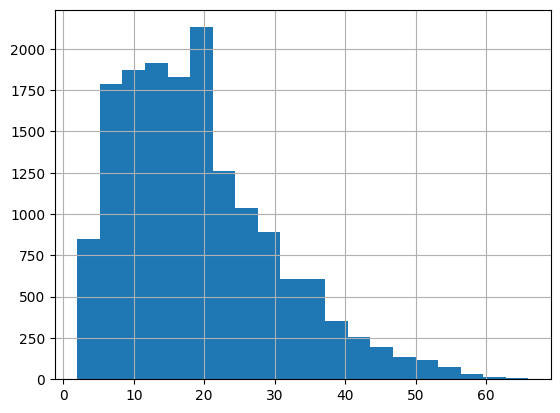

In [7]:
train_data['len'].hist(bins=20)
plt.show()

# Set up model

In [14]:
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import StepLR




import torch
import torch.nn as nn
import numpy as np


In [17]:
%%capture
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
words = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
target_tokens = [tokenizer.encode(word, add_special_tokens=False)[0] for word in words]

In [83]:
def get_masked_prediction(text):
    inputs = tokenizer(text+'. i feel [MASK] about it.', return_tensors='pt')
    masked_index = torch.where(inputs["input_ids"][0] == tokenizer.mask_token_id)[0]
    with torch.no_grad():
        output = model(**inputs).logits
    return torch.argmax(output[0, masked_index, :][0][target_tokens]).item()
    
    

# Predict validation set

In [84]:
val_data['pred'] = [get_masked_prediction(text) for text in tqdm(val_data['text'])]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [85]:

names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(val_data['label'], val_data['pred'],  output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
sadness,0.469952,0.710909,0.565847,550.000
joy,0.795107,0.369318,0.504365,704.000
love,0.216015,0.651685,0.324476,178.000
anger,0.413559,0.443636,0.428070,275.000
fear,1.000000,0.042453,0.081448,212.000
surprise,0.000000,0.000000,0.000000,81.000
accuracy,0.449000,0.449000,0.449000,0.449
macro avg,0.482439,0.369667,0.317367,2000.000
weighted avg,0.591204,0.449000,0.429516,2000.000


# Predict test set

In [79]:
test_data['pred'] = [get_masked_prediction(text) for text in tqdm(test_data['text'])]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [82]:

names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(test_data['label'],test_data['pred'], output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
sadness,0.487662,0.714286,0.579609,581.000
joy,0.773639,0.388489,0.517241,695.000
love,0.170778,0.566038,0.262391,159.000
anger,0.389961,0.367273,0.378277,275.000
fear,0.857143,0.053571,0.100840,224.000
surprise,0.000000,0.000000,0.000000,66.000
accuracy,0.444000,0.444000,0.444000,0.444
macro avg,0.446530,0.348276,0.306393,2000.000
weighted avg,0.573702,0.444000,0.432285,2000.000
